#Set Up Colab Environment

In [1]:
import tensorflow as tf

# Check if GPU is available and print the type
gpu_device_name = tf.test.gpu_device_name()
if 'GPU' not in gpu_device_name:
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(gpu_device_name))

Found GPU at: /device:GPU:0


#Mount Google Drive, Verify, and Copy Dataset

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

# Set your dataset path here
dataset_path = '/content/drive/My Drive/dataset'

# Verify that the dataset path exists
if os.path.exists(dataset_path):
    print("Dataset path verified.")
    print("Contents:", os.listdir(dataset_path)[:5])  # List some contents to verify
else:
    print("Dataset path does not exist. Please check your path.")

#Copy Files to Local Environment
!cp -r '/content/drive/My Drive/dataset' '/content/dataset'

Mounted at /content/drive
Dataset path verified.
Contents: ['004034.jpg', '004031.jpg', '004029.jpg', '004018.jpg', '004023.jpg']


#Load and Prepare Your Dataset

In [3]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array."""
    img = Image.open(path)
    img = img.resize((128, 128), Image.LANCZOS)  # Resize the image to 128x128 using LANCZOS
    img_array = np.array(img)
    return img_array

def preprocess_images(images):
    """Preprocess images by scaling them to [-1, 1]."""
    images = images.astype('float32')
    images = (images - 127.5) / 127.5  # Scale images to [-1, 1]
    return images

def load_and_prepare_dataset(directory):
    """Load and prepare the image dataset."""
    image_files = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.jpg')]
    images = np.stack([load_image_into_numpy_array(fname) for fname in image_files])
    preprocessed_images = preprocess_images(images)
    dataset = tf.data.Dataset.from_tensor_slices(preprocessed_images)
    dataset = dataset.shuffle(len(preprocessed_images)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset, preprocessed_images  # Return both the dataset and the preprocessed images array

# Local path where the dataset is stored
local_dataset_path = '/content/dataset'

# Load and prepare the dataset
train_ds, train_images = load_and_prepare_dataset(local_dataset_path)

# Output the shape of a batch to verify
for images in train_ds.take(1):
    print("Loaded batch shape:", images.shape)

# Now `train_images` is defined and can be used elsewhere if needed
print("Total images loaded:", train_images.shape)

Loaded batch shape: (32, 128, 128, 3)
Total images loaded: (5110, 128, 128, 3)


#Define Generator and Discriminator Models

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def make_generator_model():
    model = models.Sequential([
        # Start with a fully connected layer that gets reshaped into a volume
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        # Upsample to 16x16
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        # Upsample to 32x32
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        # Upsample to 64x64
        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        # Upsample to 128x128
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = models.Sequential([
        # Input shape is 128x128x3 for images
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 3)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        # Downsample to 64x64
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        # Downsample to 32x32
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# initialize your models and optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


#Define Loss Functions and Optimizers

In [10]:
# Define the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# The generator loss is a sigmoid cross entropy loss of the generated images and an array of ones
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# The discriminator loss is the sum of a sigmoid cross entropy loss of the real images and an array of ones,
# and a sigmoid cross entropy loss of the generated images and an array of zeros
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#Training Function and Training Step

In [21]:
import tensorflow as tf

# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Define the cross-entropy loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

# Define the training step with gradient accumulation
@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size, noise_dim, accum_steps):
    noise = tf.random.normal([batch_size, noise_dim])
    accumulated_gradients_gen = [tf.zeros_like(var) for var in generator.trainable_variables]
    accumulated_gradients_disc = [tf.zeros_like(var) for var in discriminator.trainable_variables]

    for _ in range(accum_steps):
        with tf.GradientTape(persistent=True) as tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_gen = tape.gradient(gen_loss, generator.trainable_variables)
        gradients_disc = tape.gradient(disc_loss, discriminator.trainable_variables)
        accumulated_gradients_gen = [accum_grad + grad for accum_grad, grad in zip(accumulated_gradients_gen, gradients_gen)]
        accumulated_gradients_disc = [accum_grad + grad for accum_grad, grad in zip(accumulated_gradients_disc, gradients_disc)]
        del tape

    generator_optimizer.apply_gradients(zip(accumulated_gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(accumulated_gradients_disc, discriminator.trainable_variables))
    return gen_loss, disc_loss

# Function for training the model
def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size, noise_dim, accum_steps):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size, noise_dim, accum_steps)
        # Print only the final epoch loss
        if epoch == epochs - 1:
            print(f'Final Epoch {epoch + 1}: Generator Loss = {gen_loss.numpy()}, Discriminator Loss = {disc_loss.numpy()}')

# Set the number of epochs for training
epochs = 1000
batch_size = 128
noise_dim = 100
accum_steps = 2

#`train_images` is defined and set up as a preprocessed dataset
BUFFER_SIZE = 5100  # Based on the total number of images in the dataset
train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(batch_size)

# Initialize generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

# Initialize optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Start the training process
train(train_ds, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size, noise_dim, accum_steps)

Final Epoch 1000: Generator Loss = 3.40234375, Discriminator Loss = 0.49169921875


#Image Generation, Saving

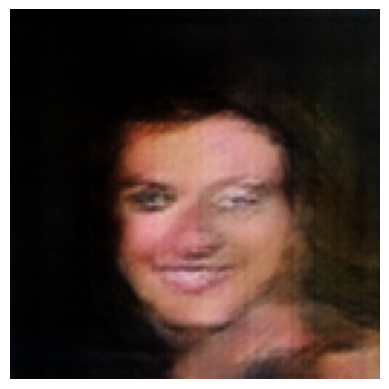

In [96]:
import matplotlib.pyplot as plt
import numpy as np

def generate_and_save_image(generator, noise_dim, save_path):
    # Generate random noise
    noise = tf.random.normal([1, noise_dim])
    # Generate image from the noise
    generated_image = generator(noise, training=False)
    # Denormalize the image to the range [0, 255]
    generated_image = (generated_image + 1) * 127.5
    # Convert the image to uint8 data type
    generated_image = tf.cast(generated_image, tf.uint8)
    # Convert the Tensor to a NumPy array
    generated_image_np = generated_image.numpy()[0]
    # Save the image
    plt.imshow(generated_image_np)
    plt.axis('off')
    plt.savefig(save_path)
    plt.show()

# Specify the path to save the generated image
save_path = 'generated_image.png'
# Generate and save the image
generate_and_save_image(generator, 100, save_path)

#Training more to improve the image quality generated


In [102]:
# Cell to continue training for more epochs
additional_epochs = 1000  # Specifying 1000 more epochs to train

# Continue the training process without reinitializing the models
train(train_ds, additional_epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size, noise_dim, accum_steps)

Final Epoch 1000: Generator Loss = 2.4375, Discriminator Loss = 0.81005859375


#Image Generation, Saving of more training model

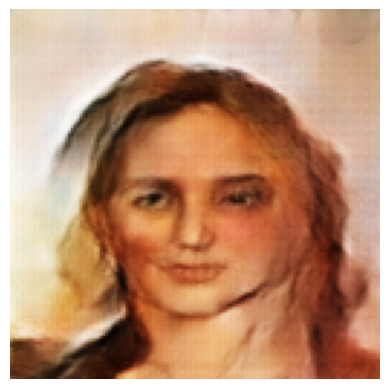

In [588]:
import matplotlib.pyplot as plt
import numpy as np

def generate_and_save_image(generator, noise_dim, save_path):
    # Generate random noise
    noise = tf.random.normal([1, noise_dim])
    # Generate image from the noise
    generated_image = generator(noise, training=False)
    # Denormalize the image to the range [0, 255]
    generated_image = (generated_image + 1) * 127.5
    # Convert the image to uint8 data type
    generated_image = tf.cast(generated_image, tf.uint8)
    # Convert the Tensor to a NumPy array
    generated_image_np = generated_image.numpy()[0]
    # Save the image
    plt.imshow(generated_image_np)
    plt.axis('off')
    plt.savefig(save_path)
    plt.show()

# Specify the path to save the generated image
save_path = 'moretrained_generated_image.png'
# Generate and save the image
generate_and_save_image(generator, 100, save_path)

#Load Original and Generated Images

In [589]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to load images from the dataset folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = image.load_img(os.path.join(folder, filename), target_size=(128, 128))
        if img is not None:
            images.append(image.img_to_array(img))
    return np.array(images)

# Path to the dataset folder and the generated image
dataset_path = '/content/dataset'
generated_image_path = '/content/moretrained_generated_image.png'

# Load original images
original_images = load_images_from_folder(dataset_path)

# Load the generated image
generated_image = image.load_img(generated_image_path, target_size=(128, 128))
generated_image_array = image.img_to_array(generated_image)

# comparing the generated image
# against each image in the original dataset
generated_images = np.array([generated_image_array for _ in range(len(original_images))])


#Compute Similarity Metrics

Average SSIM between original and generated images: 0.1819963902235031


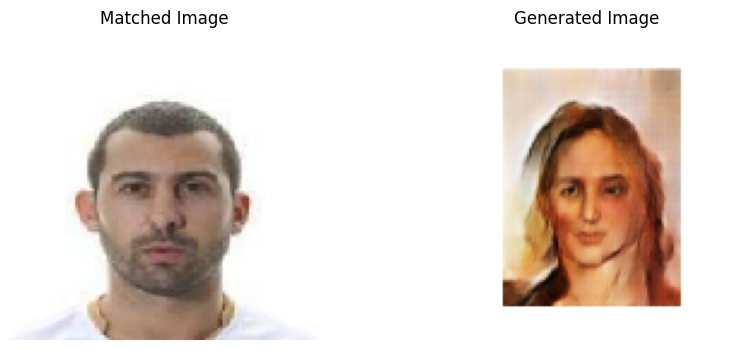

In [590]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the generated image
generated_image_path = '/content/moretrained_generated_image.png'
generated_image = tf.keras.preprocessing.image.load_img(generated_image_path)
generated_image_array = tf.keras.preprocessing.image.img_to_array(generated_image)

# Resize the generated image to match the original images' size
generated_image_resized = tf.image.resize(generated_image_array, [128, 128])
generated_image_resized = tf.cast(generated_image_resized, tf.uint8).numpy()

# Compute SSIM for each pair of original and generated images
ssim_values = []
for orig in original_images:
    # Convert the images to float32 and normalize to the range [0, 1]
    orig_resized = tf.image.resize(orig, [128, 128])  # Ensure original is resized to the same dimensions
    orig_resized = np.array(orig_resized).astype('float32') / 255.0
    anon = generated_image_resized.astype('float32') / 255.0

    # Compute SSIM, explicitly specifying the channel axis
    ssim_value = ssim(orig_resized, anon, win_size=7, data_range=anon.max() - anon.min(), channel_axis=2)
    ssim_values.append(ssim_value)

# Find the index of the original image with the highest SSIM value
best_match_index = np.argmax(ssim_values)

# Save the matched image
matched_image = original_images[best_match_index]
matched_image_resized = tf.image.resize(matched_image, [128, 128])  # Resize to match the generated image
matched_image_resized = tf.cast(matched_image_resized, tf.uint8).numpy()
plt.imsave('/content/matched_image.png', matched_image_resized)

# Calculate the average SSIM across all images
average_ssim = np.mean(ssim_values)
print(f"Average SSIM between original and generated images: {average_ssim}")

# Visual comparison for the first image as a sample
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(matched_image_resized)
plt.title("Matched Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_image_resized)
plt.title("Generated Image")
plt.axis('off')

plt.show()

# Face Similarity Evaluation with DeepFace

In [591]:
# Install necessary packages
#!pip install deepface

# Import necessary libraries
from deepface import DeepFace

# Paths to the images
generated_image_path = '/content/moretrained_generated_image.png'
matched_image_path = '/content/matched_image.png'

# Perform face similarity evaluation
result = DeepFace.verify(generated_image_path, matched_image_path)

# Print the result
print("Face similarity score:", result["verified"])


Face similarity score: False
